In [2]:
import sys
for p in sys.path:
    print(p)

/home/jack/Desktop/INFO/TWITTER/args_csv_Twython_ImageBot-master
/home/jack/hidden
/home/jack/miniconda3/lib/python39.zip
/home/jack/miniconda3/lib/python3.9
/home/jack/miniconda3/lib/python3.9/lib-dynload

/home/jack/miniconda3/lib/python3.9/site-packages


In [ ]:
#ONE TIME VIDEO POSTS
#!/home/jack/anaconda2/python

import os
import sys
sys.path.insert(1, "/home/jack/anaconda2/envs/py27/lib/python2.7/site-packages")
import twython
from twython import Twython
from PIL import Image, ImageChops, ImageDraw, ImageFont, ImageFilter

#removed keys for privacy reasons
CONSUMER_KEY = 'sdfdsfdfsgfdg5657665vbvcncnmvbm'
CONSUMER_SECRET = 'sdfdsfdfsgfdg5657665vbvcncnmvbm'
ACCESS_KEY = 'sdfdsfdfsgfdg5657665vbvcncnmvbm'
ACCESS_SECRET = 'sdfdsfdfsgfdg5657665vbvcncnmvbm'

twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET, ACCESS_KEY, ACCESS_SECRET)

video = open('/home/jack/Videos/introscale.mp4', 'rb')
response = twitter.upload_video(media=video, media_type='video/mp4')
twitter.update_status(status='#Philippines transforming photo to animation #introduction #videoexperiment', media_ids=[response['media_id']])



In [2]:
import os
import sys
import twython
from PIL import Image, ImageChops, ImageDraw, ImageFont, ImageFilter


ModuleNotFoundError: No module named 'twython'

In [9]:
from APIkeys import KEYS
CONSUMER_KEY = KEYS()[0]
CONSUMER_SECRET =  KEYS()[1]
ACCESS_KEY =  KEYS()[2]
ACCESS_SECRET =  KEYS()[3]






In [6]:
import APIkeys
CONSUMER_KEY = APIkeys.KEYS[0]

TypeError: 'function' object is not subscriptable

In [118]:
# imports and basic notebook setup
from cStringIO import StringIO
import numpy as np
import scipy.ndimage as nd
import PIL.Image
from IPython.display import clear_output, Image, display
from google.protobuf import text_format

import caffe

# If your GPU supports CUDA and Caffe was built with CUDA support,
# uncomment the following to run Caffe operations on the GPU.
# caffe.set_mode_gpu()
# caffe.set_device(0) # select GPU device if multiple devices exist

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [119]:
model_path = '/home/jack/Desktop/deep-dream-generator/notebooks/models/googlenet_places365/' # substitute your path here
net_fn   = model_path + 'deploy.prototxt'
param_fn = model_path + 'googlenet_places365.caffemodel'


#model_path = 'models/jcaffe/may16/' # substitute your path here
#net_fn   = model_path + 'deploy.prototxt'
#param_fn = model_path + 'may16.caffemodel'





# Patching model to be able to compute gradients.
# Note that you can also manually add "force_backward: true" line to "deploy.prototxt".
model = caffe.io.caffe_pb2.NetParameter()
text_format.Merge(open(net_fn).read(), model)
model.force_backward = True
open('tmp.prototxt', 'w').write(str(model))

net = caffe.Classifier('tmp.prototxt', param_fn,
                       mean = np.float32([104.0, 116.0, 122.0]), # ImageNet mean, training set dependent
                       channel_swap = (2,1,0)) # the reference model has channels in BGR order instead of RGB

# a couple of utility functions for converting to and from Caffe's input image layout
def preprocess(net, img):
    return np.float32(np.rollaxis(img, 2)[::-1]) - net.transformer.mean['data']
def deprocess(net, img):
    return np.dstack((img + net.transformer.mean['data'])[::-1])

##  Producing dreams

In [120]:
def objective_L2(dst):
    dst.diff[:] = dst.data 

def make_step(net, step_size=1.5, end='pool2', 
              jitter=32, clip=True, objective=objective_L2):
    '''Basic gradient ascent step.'''

    src = net.blobs['data'] # input image is stored in Net's 'data' blob
    dst = net.blobs[end]

    ox, oy = np.random.randint(-jitter, jitter+1, 2)
    src.data[0] = np.roll(np.roll(src.data[0], ox, -1), oy, -2) # apply jitter shift
            
    net.forward(end=end)
    objective(dst)  # specify the optimization objective
    net.backward(start=end)
    g = src.diff[0]
    # apply normalized ascent step to the input image
    src.data[:] += step_size/np.abs(g).mean() * g

    src.data[0] = np.roll(np.roll(src.data[0], -ox, -1), -oy, -2) # unshift image
            
    if clip:
        bias = net.transformer.mean['data']
        src.data[:] = np.clip(src.data, -bias, 255-bias)    

Next we implement an ascent through different scales. We call these scales "octaves".

In [121]:
def deepdream(net, base_img, iter_n=10, octave_n=4, octave_scale=1.4, 
              end='pool5', clip=True, **step_params):
    # prepare base images for all octaves
    octaves = [preprocess(net, base_img)]
    for i in xrange(octave_n-1):
        octaves.append(nd.zoom(octaves[-1], (1, 1.0/octave_scale,1.0/octave_scale), order=1))
    
    src = net.blobs['data']
    detail = np.zeros_like(octaves[-1]) # allocate image for network-produced details
    for octave, octave_base in enumerate(octaves[::-1]):
        h, w = octave_base.shape[-2:]
        if octave > 0:
            # upscale details from the previous octave
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1.0*h/h1,1.0*w/w1), order=1)

        src.reshape(1,3,h,w) # resize the network's input image size
        src.data[0] = octave_base+detail
        for i in xrange(iter_n):
            make_step(net, end=end, clip=clip, **step_params)
            
            # visualization
            vis = deprocess(net, src.data[0])
            if not clip: # adjust image contrast if clipping is disabled
                vis = vis*(255.0/np.percentile(vis, 99.98))
            showarray(vis)
            print octave, i, end, vis.shape
            clear_output(wait=True)
            
        # extract details produced on the current octave
        detail = src.data[0]-octave_base
    # returning the resulting image
    return deprocess(net, src.data[0])

In [ ]:
#If you have no image you may generate a random noise image fromthe code below.

#OR:
#You may download an image from the internet with !wget

!wget -O cloud.jpg \
https://commons.wikimedia.org/wiki/File:Appearance_of_sky_for_weather_forecast,_Dhaka,_Bangladesh.JPG

In [ ]:
# start with a gray image with a little noise
img_noise = np.random.uniform(size=(740,740,3)) + 200.0
#img_noise = np.random.rand(size=(740,740,3)) + 100.0

In [ ]:
# Read in an image to "DREAM"

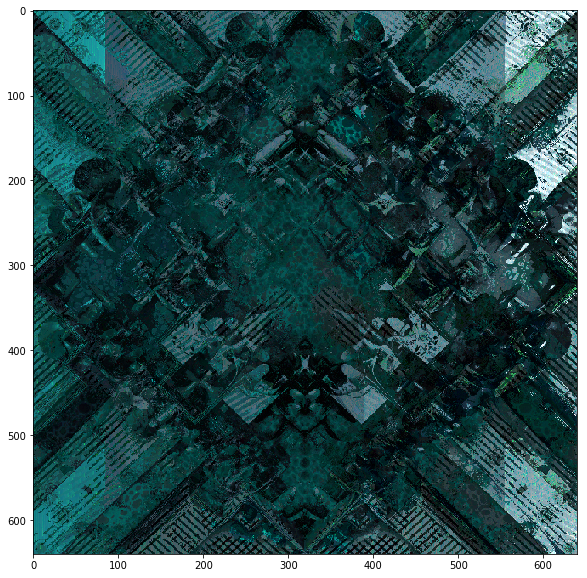

In [83]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = (20.0, 10.0)
import matplotlib.image as mpimg
import numpy as np
img=mpimg.imread('junk/exchange20170827114052.png')
img0 = np.float32(img)[:,:,:3]
imgplot = plt.imshow(img0)
#img = np.float32(PIL.Image.open('test_.jpg'))
#showarray(img)

In [35]:
from PIL import Image
# open an image file (.jpg or.png) you have in the working folder
im1 = Image.open("junk/exchange20170827114052.png")
# multiply each pixel 
# Best with .jpg and .png files, darker < 1.0 < lighter
# (.bmp and .gif files do not work well)
# note that lambda is akin to a one-line function
im2 = im1.point(lambda p: p * 1.8)

im2.show()
# save modified image to working folder as Audi2.jpg
im2.save("result.jpg")

# NOTE IMPORTANT TO PUT THE IPython Image back after loading "from PIL import Image"
from IPython.display import clear_output, Image, display


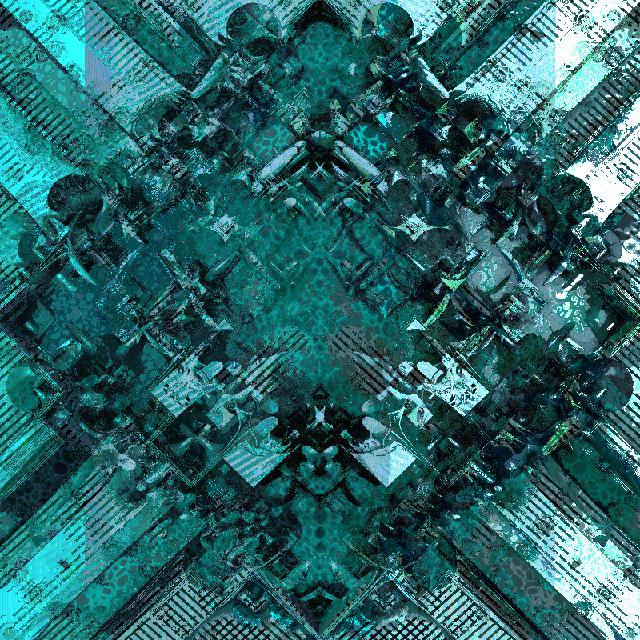

In [122]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = (20.0, 10.0)
import matplotlib.image as mpimg
import numpy as np
img=mpimg.imread('result.jpg')
img0 = np.float32(img)[:,:,:3]
#imgplot = plt.imshow(img0)
#img = np.float32(PIL.Image.open('result.jpg'))
showarray(img0)

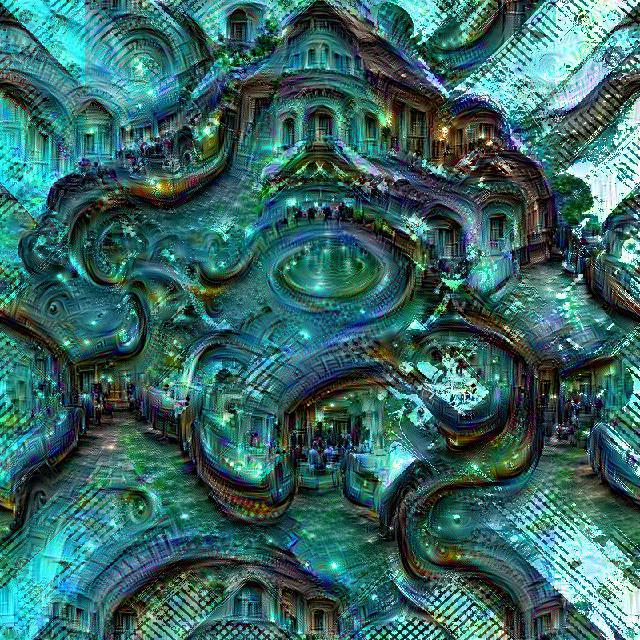

7 19 inception_4b/5x5_reduce (640, 640, 3)


In [123]:
_=deepdream(net, img0, iter_n=20, octave_n=8, end='inception_4b/5x5_reduce')
#_=deepdream(net, img0, end='inception_5b/5x5')

In [38]:
import cv2
cv2.imwrite("mydream2.png", _)

True

In [77]:
#ONE TIME MANUAL POSTS
#!/home/jack/anaconda2/python
import random
from random import randint
import time
import markovify
import os
import sys
sys.path.insert(1, "/home/jack/anaconda2/envs/py27/lib/python2.7/site-packages")
import twython
from twython import Twython
from PIL import Image, ImageChops, ImageDraw, ImageFont, ImageFilter
custom = "junk/exchange20170828094257.png"
filename0=(custom)
def generate_the_word(infile):
        with open(infile) as f:
            contents_of_file = f.read()
        lines = contents_of_file.splitlines()
        line_number = random.randrange(0, len(lines))
        return lines[line_number]

def draw_text_with_halo(img, position, text, font, col, halo_col):
    #halo = Image.new('RGBA', img.size, (0, 0, 0, 0))
    halo = Image.new('RGBA', img.size, (255,255,255, 0))
    ImageDraw.Draw(halo).text(position, text, font = font, fill = halo_col)
    blurred_halo = halo.filter(ImageFilter.BLUR)
    ImageDraw.Draw(blurred_halo).text(position, text, font = font, fill = col)
    return Image.composite(img, blurred_halo, ImageChops.invert(blurred_halo))

if __name__ == '__main__':
    inp = Image.open(filename0)
    font = ImageFont.truetype("/home/jack/.fonts/Exo-Black.ttf", 35)
    #font = ImageFont.truetype("/home/jack/.fonts/GRUNTREAPER.ttf", 70)
    #font = ImageFont.truetype("/home/jack/.fonts/Nightbird.ttf", 70)
    #font = ImageFont.truetype("/home/jack/.fonts/Nightbird.ttf", 70)
    #font = ImageFont.truetype("/home/jack/.fonts/Punktype.ttf", 70)
    text_col = (255,200,0) # bright green
    halo_col = (0, 0,0)   # black
    #text_col = (230, 230,250) # bright green
    #halo_col = (0,0,0)  # black (0,0,0)    
    textin = (generate_the_word("wordcloud.txt"))
    #i2 = draw_text_with_halo(inp, (15, 8), "HIGH FIVE", font, text_col, halo_col)
    i2 = draw_text_with_halo(inp, (20, 10), "DEEP-DREAM - inception_3b/5x5_reduce", font, text_col, halo_col)
    #txt = Image.new('RGBA', i.size, (255,255,255,0))

    # get a font
    fnt = ImageFont.truetype("/home/jack/.fonts/Exo-Black.ttf", 20)
    
    # get a drawing context
    width, height = inp.size
    marginx = 225
    marginy = 35
    x = width - marginx
    y = height - marginy
    signature_ = "The TwitterBot Project" 
    text_col2 = (15, 5, 10) # bright green
    halo_col2 = (255, 255,255) 
    #text_col2 = (255, 255,255) # signature white
    #halo_col2 = (0, 0, 0)   # signature black
    txt=draw_text_with_halo(i2,(x,y), signature_, fnt, text_col2, halo_col2)
    out = Image.alpha_composite(i2, txt)
    out.save("tmp/TM_POST.jpg")

#removed keys for privacy reasons
CONSUMER_KEY = 'sdfdsfdfsgfdg5657665vbvcncnmvbm'
CONSUMER_SECRET = 'sdfdsfdfsgfdg5657665vbvcncnmvbm'
ACCESS_KEY = 'sdfdsfdfsgfdg5657665vbvcncnmvbm'
ACCESS_SECRET = 'sdfdsfdfsgfdg5657665vbvcncnmvbm'

twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET, ACCESS_KEY, ACCESS_SECRET)
#path = 'images/NewFolder'
f = open("art.txt")
text = f.read()
# Build the model.
text_model = markovify.Text(text)
# Print randomly-generated sentences of no more than 140 characters
#http://paulbourke.net/fractals/
#STR = (text_model.make_short_sentence(140))
STR = ("Toay I will #DEEP-Dream Same image different inception layer - This one uses the Mona Lisa palette for colors")
#PATH = "/home/jack/Desktop/deep-dream-generator/notebooks/STUFF/experiment/experiment8.jpg"
PATH = "tmp/TM_POST.jpg"
# 1 , 2, 3, 12, 5, 15, 8, 6
#photo = open('/home/jack/Desktop/deep-dream-generator/notebooks/images/'+file_list[rnd]+'.jpg','rb')

#photo = open(PATH,'rb')
#response = twitter.upload_media(media=photo)
#twitter.update_status(status=STR, media_ids=[response['media_id']])
!showme tmp/TM_POST.jpg

# HOW to post a video

In [ ]:
name: "pool1/norm1"
name: "conv2/3x3_reduce"
name: "conv2/relu_3x3_reduce"
name: "conv2/3x3"
name: "conv2/relu_3x3"
name: "conv2/norm2"
bottom: "conv2/3x3"
top: "pool2/3x3_s2"
top: "inception_3a/1x1"
top: "inception_3a/1x1"
top: "inception_3a/3x3_reduce"
top: "inception_3a/3x3_reduce"
top: "inception_3a/5x5_reduce"
top: "inception_3a/pool"
top: "inception_3a/pool_proj"
top: "inception_3a/output"
top: "inception_3b/1x1"
top: "inception_3b/3x3_reduce"
top: "inception_3b/3x3"
top: "inception_3b/5x5_reduce"
top: "inception_3b/5x5_reduce"
top: "inception_3b/5x5"
top: "inception_3b/5x5"
top: "inception_3b/pool"
top: "inception_3b/pool_proj"
name: "inception_3b/relu_pool_proj"
type: "ReLU"
bottom: "inception_3b/pool_proj"
top: "inception_3b/pool_proj"
name: "inception_3b/output"
bottom: "inception_3b/1x1"
bottom: "inception_3b/3x3"
bottom: "inception_3b/5x5"
bottom: "inception_3b/pool_proj"
top: "inception_3b/output"
name: "pool3/3x3_s2"
bottom: "inception_3b/output"
top: "pool3/3x3_s2"
top: "inception_4a/1x1"
top: "inception_4a/1x1"
top: "inception_4a/3x3_reduce"
top: "inception_4a/3x3_reduce"
top: "inception_4a/3x3"
top: "inception_4a/3x3"
top: "inception_4a/5x5_reduce"
top: "inception_4a/5x5_reduce"
top: "inception_4a/5x5"
top: "inception_4a/5x5"
top: "inception_4a/pool"
top: "inception_4a/pool_proj"
top: "inception_4a/pool_proj"
top: "inception_4a/output"
top: "inception_4b/1x1"
top: "inception_4b/1x1"
top: "inception_4b/3x3_reduce"
top: "inception_4b/3x3_reduce"
top: "inception_4b/3x3"
top: "inception_4b/5x5_reduce"
top: "inception_4b/5x5_reduce"
top: "inception_4b/5x5"
top: "inception_4b/5x5"
top: "inception_4b/pool"
top: "inception_4b/pool_proj"
top: "inception_4b/pool_proj"
top: "inception_4b/output"
top: "inception_4c/1x1"
top: "inception_4c/1x1"
top: "inception_4c/3x3_reduce"
top: "inception_4c/3x3_reduce"
top: "inception_4c/3x3"
top: "inception_4c/3x3"
top: "inception_4c/5x5_reduce"
top: "inception_4c/5x5_reduce"
top: "inception_4c/5x5"
top: "inception_4c/5x5"
top: "inception_4c/pool"
top: "inception_4c/pool_proj"
top: "inception_4c/pool_proj"
top: "inception_4c/output"
top: "inception_4d/1x1"
top: "inception_4d/1x1"
top: "inception_4d/3x3_reduce"
top: "inception_4d/3x3_reduce"
top: "inception_4d/3x3"
top: "inception_4d/3x3"
top: "inception_4d/5x5_reduce"
top: "inception_4d/5x5_reduce"
top: "inception_4d/5x5"
top: "inception_4d/5x5"
top: "inception_4d/pool"
top: "inception_4d/pool_proj"
top: "inception_4d/pool_proj"
top: "inception_4d/output"
top: "inception_4e/1x1"
top: "inception_4e/1x1"
top: "inception_4e/3x3_reduce"
top: "inception_4e/3x3_reduce"
top: "inception_4e/3x3"
top: "inception_4e/3x3"
top: "inception_4e/5x5_reduce"
top: "inception_4e/5x5_reduce"
top: "inception_4e/5x5"
top: "inception_4e/5x5"
top: "inception_4e/pool"
top: "inception_4e/pool_proj"
top: "inception_4e/pool_proj"
top: "inception_4e/output"
top: "pool4/3x3_s2"
top: "inception_5a/1x1"
top: "inception_5a/1x1"
top: "inception_5a/3x3_reduce"
top: "inception_5a/3x3_reduce"
top: "inception_5a/3x3"
top: "inception_5a/3x3"
top: "inception_5a/5x5_reduce"
top: "inception_5a/5x5_reduce"
top: "inception_5a/5x5"
top: "inception_5a/5x5"
top: "inception_5a/pool"
top: "inception_5a/pool_proj"
top: "inception_5a/pool_proj"
top: "inception_5a/output"
top: "inception_5b/1x1"
top: "inception_5b/1x1"
top: "inception_5b/3x3_reduce"
top: "inception_5b/3x3_reduce"
top: "inception_5b/3x3"
top: "inception_5b/3x3"
top: "inception_5b/5x5_reduce"
top: "inception_5b/5x5_reduce"
top: "inception_5b/5x5"
top: "inception_5b/5x5"
top: "inception_5b/pool"
top: "inception_5b/pool_proj"
top: "inception_5b/pool_proj"
top: "inception_5b/output"
top: "pool5/7x7_s1"
top: "pool5/7x7_s1"


In [ ]:
#ONE TIME VIDEO POSTS
#!/home/jack/anaconda2/python

import os
import sys
sys.path.insert(1, "/home/jack/anaconda2/envs/py27/lib/python2.7/site-packages")
import twython
from twython import Twython
from PIL import Image, ImageChops, ImageDraw, ImageFont, ImageFilter

#removed keys for privacy reasons
CONSUMER_KEY = 'sdfdsfdfsgfdg5657665vbvcncnmvbm'
CONSUMER_SECRET = 'sdfdsfdfsgfdg5657665vbvcncnmvbm'
ACCESS_KEY = 'sdfdsfdfsgfdg5657665vbvcncnmvbm'
ACCESS_SECRET = 'sdfdsfdfsgfdg5657665vbvcncnmvbm'

twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET, ACCESS_KEY, ACCESS_SECRET)

video = open('/home/jack/Videos/introscale.mp4', 'rb')
response = twitter.upload_video(media=video, media_type='video/mp4')
twitter.update_status(status='#Philippines transforming photo to animation #introduction #videoexperiment', media_ids=[response['media_id']])



In [51]:
!wget -O temp.png http://images.mentalfloss.com/sites/default/files/mona_1.png

--2017-08-28 09:42:33--  http://images.mentalfloss.com/sites/default/files/mona_1.png
Resolving images.mentalfloss.com (images.mentalfloss.com)... 50.22.188.78
Connecting to images.mentalfloss.com (images.mentalfloss.com)|50.22.188.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 552976 (540K) [image/png]
Saving to: ‘temp.png’

temp.png            100%[===================>] 540.02K   106KB/s    in 5.1s    

2017-08-28 09:42:39 (106 KB/s) - ‘temp.png’ saved [552976/552976]



In [52]:
import os
import sys
from PIL import Image
import shutil
from PIL import Image
import time

#input2='/home/jack/Desktop/deep-dream-generator/notebooks/bugs/butterflies/000163.jpg'
input1='mydream1.png'
#input1='/home/jack/Desktop/imagebot/colorful/20170824124329.jpg'
input2='temp.png'
shutil.copy2(input1, 'instagram/') # complete target filename given
shutil.copy2(input2, 'instagram/')# target filename is /dst/dir/file.ext

aa = Image.open(input1).convert("RGB")
#bb = Image.open("/home/jack/Documents/GG.jpg").convert("RGB")
bb = Image.open(input2).convert("RGB")
xx=aa.resize((640,640), Image.NEAREST)
yy=bb.resize((640,640), Image.NEAREST)
xx.save("junk/aa.png")
yy.save("junk/bb.png")
src = Image.open('junk/aa.png').convert('RGB')
dst = Image.open('junk/bb.png').convert('RGB')
src.save("junk/aa.png")
dst.save("junk/bb.png")


n = 5 #number of partitions per channel.


src_handle = Image.open("junk/bb.png")
dst_handle = Image.open("junk/aa.png")
src = src_handle.load()
dst = dst_handle.load()
assert src_handle.size[0]*src_handle.size[1] == dst_handle.size[0]*dst_handle.size[1],"images must be same size"

def makePixelList(img):
    l = []
    for x in range(img.size[0]):
        for y in range(img.size[1]):
            l.append((x,y))
    return l

lsrc = makePixelList(src_handle)
ldst = makePixelList(dst_handle)

def sortAndDivide(coordlist,pixelimage,channel): #core
    global src,dst,n
    retlist = []
    #sort
    coordlist.sort(key=lambda t: pixelimage[t][channel])
    #divide
    partitionLength = int(len(coordlist)/n)
    if partitionLength <= 0:
        partitionLength = 1
    if channel < 2:
        for i in range(0,len(coordlist),partitionLength):
            retlist += sortAndDivide(coordlist[i:i+partitionLength],pixelimage,channel+1)
    else:
        retlist += coordlist
    return retlist

print(src[lsrc[0]])

lsrc = sortAndDivide(lsrc,src,0)
ldst = sortAndDivide(ldst,dst,0)

for i in range(len(ldst)):
    dst[ldst[i]] = src[lsrc[i]]
    
    
filename = time.strftime("junk/exchange%Y%m%d%H%M%S.png")

dst_handle.save(filename)

shutil.copy2(filename, "instagram/")
print filename

(160, 142, 53)
junk/exchange20170828094257.png


In [53]:
!showme junk/exchange20170828094257.png


# Some Utilities

In [45]:
from PIL import Image

image = Image.open('noise.png')
image = image.convert('RGB')
image = image.resize((200, 150), Image.ANTIALIAS)
image = image.convert('P', palette=Image.ADAPTIVE, colors=256)
image = image.convert('L', palette=Image.ADAPTIVE, colors=256)
image.save('outnoise.png')

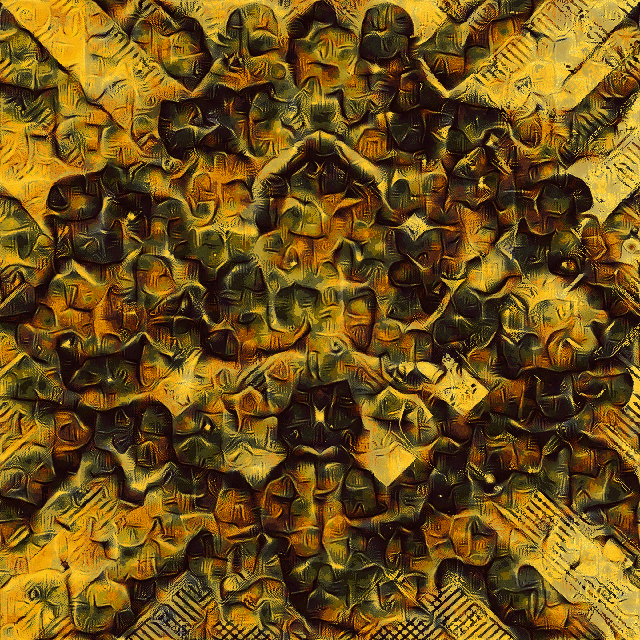

In [96]:
from PIL import Image
front = Image.open("instagram/exchange20170828094257.png").convert('RGBA')
front

In [107]:
%reset -f

# resize image

In [76]:
from PIL import Image
img = Image.open('specral.jpg')
dim = (1000, 1000)
newimg = img.resize(dim)
# save the new image to a new filename
newimg.save('specral__.jpg')
import PIL.Image
from IPython.display import clear_output, Image, display

# resize plot size

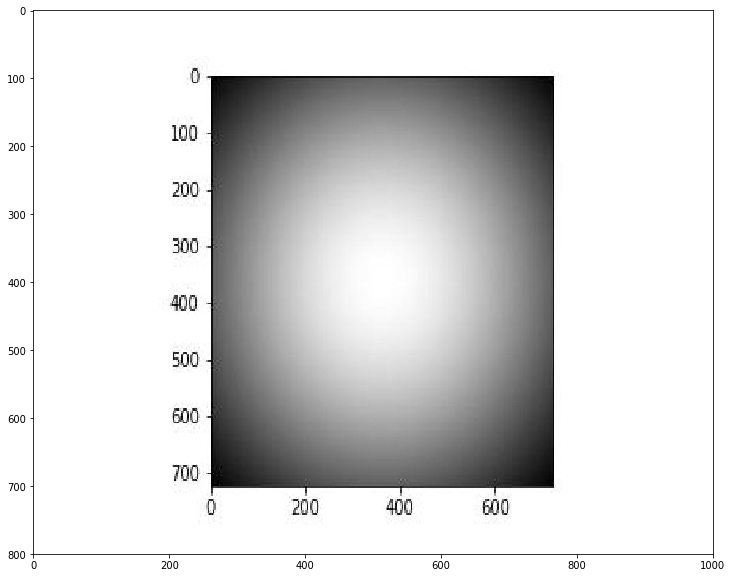

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = (20.0, 10.0)
import matplotlib.image as mpimg
import numpy as np
img=mpimg.imread('test__.jpg')
imgplot = plt.imshow(img)
#img = np.float32(PIL.Image.open('test_.jpg'))
#showarray(img)

In [7]:
!ls images

junk	    Sranger.jpg		  Sranger-Tri-001-crop2a.jpg  tmp.jpg
ranger.jpg  Sranger-Tri-001a.jpg  Sranger-Tri-001-crop2b.jpg  TM_POST.jpg


In [8]:
from PIL import Image
#import PIL.Image
#from IPython.display import clear_output, Image, display
img = Image.open('images/Sranger.jpg')
img0 = np.float32(img)[:,:,:3]

In [10]:
import cv2
#image_30871558599.png
img = cv2.imread('/home/jack/Desktop/deep-dream-generator/notebooks/STUFF/experiment/experiment11.png')
img0 = np.float32(img)[:,:,:3]
cv2.imshow("img", img0)

Running the next code cell starts the detail generation process. You may see how new patterns start to form, iteration by iteration, octave by octave.

In [11]:
# start with a gray image with a little noise
img_noise = np.random.uniform(size=(640,640,3))


In [39]:
cv2.imwrite("deep-dream3.jpg", _)

True

In [ ]:
_=deepdream(net, img, iter_n=20, octave_n=8, end='inception_5b/pool5')

In [ ]:
_=deepdream(net, img, iter_n=20, octave_n=8)

In [ ]:
_=deepdream(net, img, iter_n=20, octave_n=8)

In [ ]:
_=deepdream(net, img, end='norm1')

In [ ]:
test = deepdream(net, _, iter_n=3, jitter=5, octave_n=8, end='inception_5b/pool_proj')

In [ ]:
test = deepdream(net, img, iter_n=3, octave_n=8, end='inception_5b/pool_proj')

In [ ]:
_=deepdream(net, img, end='inception_5b/output')

In [117]:
net.blobs.keys()

NameError: name 'net' is not defined

In [ ]:
h, w = frame.shape[:2]
s = 0.1 # scale coefficient
for i in xrange(75):
    frame = deepdream(net, frame, iter_n=15, octave_n=8, end='pool5')
    PIL.Image.fromarray(np.uint8(frame)).save("junk/DREAM_%04d.jpg"%frame_i)
    frame = nd.affine_transform(frame, [1-s,1-s,1], [h*s/2,w*s/2,0], order=1)
    frame_i += 1

We encourage readers to experiment with layer selection to see how it affects the results. Execute the next code cell to see the list of different layers. You can modify the `make_step` function to make it follow some different objective, say to select a subset of activations to maximize, or to maximize multiple layers at once. There is a huge design space to explore!

What if we feed the `deepdream` function its own output, after applying a little zoom to it? It turns out that this leads to an endless stream of impressions of the things that the network saw during training. Some patterns fire more often than others, suggestive of basins of attraction.

We will start the process from the same sky image as above, but after some iteration the original image becomes irrelevant; even random noise can be used as the starting point.

Be careful running the code above, it can bring you into very strange realms!

## Controlling dreams

The image detail generation method described above tends to produce some patterns more often the others. One easy way to improve the generated image diversity is to tweak the optimization objective. Here we show just one of many ways to do that. Let's use one more input image. We'd call it a "*guide*".

Note that the neural network we use was trained on images downscaled to 224x224 size. So high resolution images might have to be downscaled, so that the network could pick up their features. The image we use here is already small enough.

Now we pick some target layer and extract guide image features.

In [21]:
end = 'pool5'
h, w = guide.shape[:2]
src, dst = net.blobs['data'], net.blobs[end]
src.reshape(1,3,h,w)
src.data[0] = preprocess(net, guide)
net.forward(end=end)
guide_features = dst.data[0].copy()

showarray(guide_features)

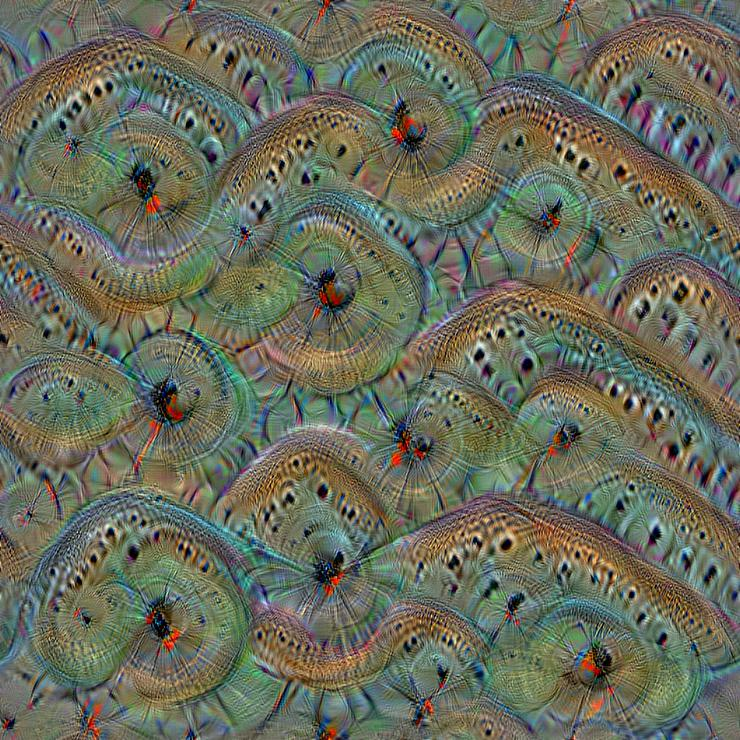

3 49 pool5 (740, 740, 3)


In [24]:
def objective_guide(dst):
    x = dst.data[0].copy()
    y = guide_features
    ch = x.shape[0]
    x = x.reshape(ch,-1)
    y = y.reshape(ch,-1)
    A = x.T.dot(y) # compute the matrix of dot-products with guide features
    dst.diff[0].reshape(ch,-1)[:] = y[:,A.argmax(1)] # select ones that match best

_=deepdream(net, img_noise, iter_n=50,end=end, objective=objective_guide)

In [39]:
# start with a gray image with a little noise
img_noise = np.random.uniform(size=(740,740,3)) + 100.0

In [57]:
#All in One Guide Experiment
guide0 = np.float32(PIL.Image.open('bugs/spiders/thumbs/0028.png'))
end = 'pool5'
h, w = guide0.shape[:2]
src, dst = net.blobs['data'], net.blobs[end]
src.reshape(1,3,h,w)
src.data[0] = preprocess(net, guide0)
net.forward(end=end)

guide_features0 = dst.data[0].copy()
def objective_guide0(dst):
    x = dst.data[0].copy()
    y = guide_features0
    ch = x.shape[0]
    x = x.reshape(ch,-1)
    y = y.reshape(ch,-1)
    A = x.T.dot(y) # compute the matrix of dot-products with guide features
    dst.diff[0].reshape(ch,-1)[:] = y[:,A.argmax(1)] # select ones that match best
#spider=deepdream(net, _, jitter=3, iter_n=50,end=end, octave_n=8, objective=objective_guide0)
spider=deepdream(net, noise, jitter=3, iter_n=50,end=end, octave_n=8, objective=objective_guide0)

ValueError: 'axis' arg requires -1 <= axis < 1, but 2 was passed in

# guide 1

In [27]:
end = 'pool5'
h, w = guide2.shape[:2]
src, dst = net.blobs['data'], net.blobs[end]
src.reshape(1,3,h,w)
src.data[0] = preprocess(net, guide2)
net.forward(end=end)
guide_features2 = dst.data[0].copy()

This way we can affect the style of generated images without using a different training set.

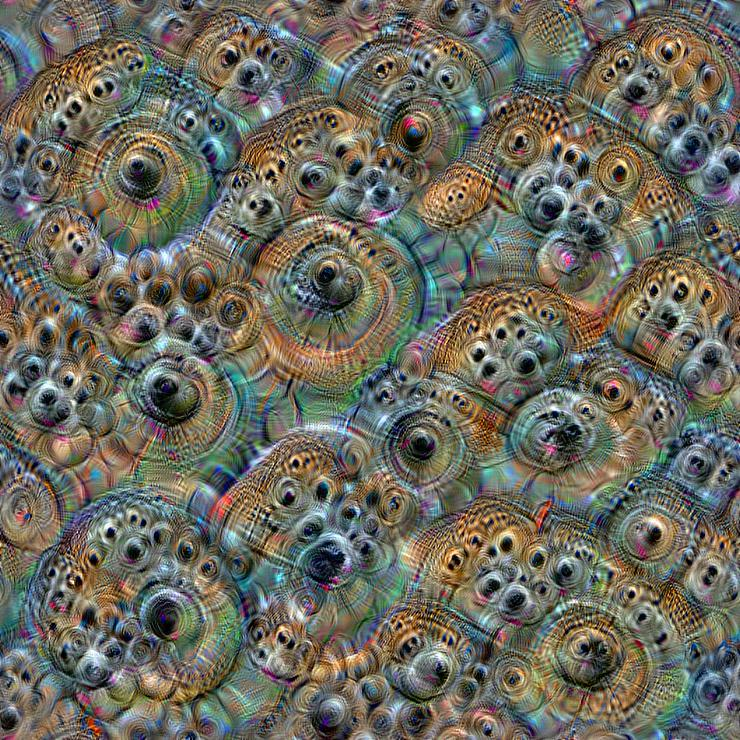

3 49 pool5 (740, 740, 3)


In [28]:
def objective_guide(dst):
    x = dst.data[0].copy()
    y = guide_features2
    ch = x.shape[0]
    x = x.reshape(ch,-1)
    y = y.reshape(ch,-1)
    A = x.T.dot(y) # compute the matrix of dot-products with guide features
    dst.diff[0].reshape(ch,-1)[:] = y[:,A.argmax(1)] # select ones that match best

gear=deepdream(net, _, jitter=3, iter_n=50,end=end, ovtave_n=8, objective=objective_guide)

In [27]:
end = 'pool5'
h, w = guide2.shape[:2]
src, dst = net.blobs['data'], net.blobs[end]
src.reshape(1,3,h,w)
src.data[0] = preprocess(net, guide2)
net.forward(end=end)
guide_features2 = dst.data[0].copy()

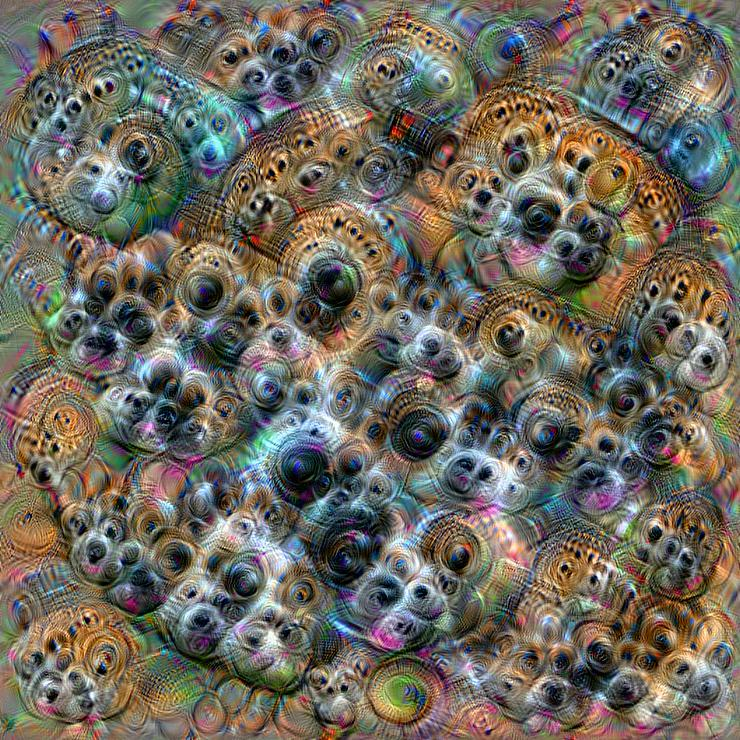

7 49 pool5 (740, 740, 3)


In [31]:
def objective_guide1(dst):
    x = dst.data[0].copy()
    y = guide_features2
    ch = x.shape[0]
    x = x.reshape(ch,-1)+2
    y = y.reshape(ch,-1)+2
    A = x.T.dot(y) # compute the matrix of dot-products with guide features
    dst.diff[0].reshape(ch,-1)[:] = y[:,A.argmax(1)] # select ones that match best

gear=deepdream(net, _, jitter=3, iter_n=50,end=end, octave_n=8, objective=objective_guide1)

# All in One Experiment

In [ ]:
#All in One Guide Experiment
guide3 = np.float32(PIL.Image.open('bugs/spiders/thumbs/0028.png'))
end = 'pool5'
h, w = guide3.shape[:2]
src, dst = net.blobs['data'], net.blobs[end]
src.reshape(1,3,h,w)
src.data[0] = preprocess(net, guide3)
net.forward(end=end)
guide_features3 = dst.data[0].copy()
def objective_guide3(dst):
    x = dst.data[0].copy()
    y = guide_features3
    ch = x.shape[0]
    x = x.reshape(ch,-1)+2
    y = y.reshape(ch,-1)+2
    A = x.T.dot(y) # compute the matrix of dot-products with guide features
    dst.diff[0].reshape(ch,-1)[:] = y[:,A.argmax(1)] # select ones that match best

spider=deepdream(net, _, jitter=3, iter_n=50,end=end, octave_n=8, objective=objective_guide3)

In [53]:
#Unknown result 
from PIL import Image

def get_white_noise_image(width, height):
    pil_map = Image.new("RGBA", (width, height), 255)
    random_grid = map(lambda x: (
            int(random.random() * 256),
            int(random.random() * 256),
            int(random.random() * 256)
        ), [0] * width * height)
    somenoise = pil_map.putdata(random_grid)
    return pil_map

In [ ]:
# %load /usr/lib/python2.7/unittest/main.py
"""Unittest main program"""

import sys
import os
import types

from . import loader, runner
from .signals import installHandler

__unittest = True

FAILFAST     = "  -f, --failfast   Stop on first failure\n"
CATCHBREAK   = "  -c, --catch      Catch control-C and display results\n"
BUFFEROUTPUT = "  -b, --buffer     Buffer stdout and stderr during test runs\n"

USAGE_AS_MAIN = """\
Usage: %(progName)s [options] [tests]

Options:
  -h, --help       Show this message
  -v, --verbose    Verbose output
  -q, --quiet      Minimal output
%(failfast)s%(catchbreak)s%(buffer)s
Examples:
  %(progName)s test_module               - run tests from test_module
  %(progName)s module.TestClass          - run tests from module.TestClass
  %(progName)s module.Class.test_method  - run specified test method

[tests] can be a list of any number of test modules, classes and test
methods.

Alternative Usage: %(progName)s discover [options]

Options:
  -v, --verbose    Verbose output
%(failfast)s%(catchbreak)s%(buffer)s  -s directory     Directory to start discovery ('.' default)
  -p pattern       Pattern to match test files ('test*.py' default)
  -t directory     Top level directory of project (default to
                   start directory)

For test discovery all test modules must be importable from the top
level directory of the project.
"""

USAGE_FROM_MODULE = """\
Usage: %(progName)s [options] [test] [...]

Options:
  -h, --help       Show this message
  -v, --verbose    Verbose output
  -q, --quiet      Minimal output
%(failfast)s%(catchbreak)s%(buffer)s
Examples:
  %(progName)s                               - run default set of tests
  %(progName)s MyTestSuite                   - run suite 'MyTestSuite'
  %(progName)s MyTestCase.testSomething      - run MyTestCase.testSomething
  %(progName)s MyTestCase                    - run all 'test*' test methods
                                               in MyTestCase
"""



class TestProgram(object):
    """A command-line program that runs a set of tests; this is primarily
       for making test modules conveniently executable.
    """
    USAGE = USAGE_FROM_MODULE

    # defaults for testing
    failfast = catchbreak = buffer = progName = None

    def __init__(self, module='__main__', defaultTest=None, argv=None,
                    testRunner=None, testLoader=loader.defaultTestLoader,
                    exit=True, verbosity=1, failfast=None, catchbreak=None,
                    buffer=None):
        if isinstance(module, basestring):
            self.module = __import__(module)
            for part in module.split('.')[1:]:
                self.module = getattr(self.module, part)
        else:
            self.module = module
        if argv is None:
            argv = sys.argv

        self.exit = exit
        self.failfast = failfast
        self.catchbreak = catchbreak
        self.verbosity = verbosity
        self.buffer = buffer
        self.defaultTest = defaultTest
        self.testRunner = testRunner
        self.testLoader = testLoader
        self.progName = os.path.basename(argv[0])
        self.parseArgs(argv)
        self.runTests()

    def usageExit(self, msg=None):
        if msg:
            print msg
        usage = {'progName': self.progName, 'catchbreak': '', 'failfast': '',
                 'buffer': ''}
        if self.failfast != False:
            usage['failfast'] = FAILFAST
        if self.catchbreak != False:
            usage['catchbreak'] = CATCHBREAK
        if self.buffer != False:
            usage['buffer'] = BUFFEROUTPUT
        print self.USAGE % usage
        sys.exit(2)

    def parseArgs(self, argv):
        if len(argv) > 1 and argv[1].lower() == 'discover':
            self._do_discovery(argv[2:])
            return

        import getopt
        long_opts = ['help', 'verbose', 'quiet', 'failfast', 'catch', 'buffer']
        try:
            options, args = getopt.getopt(argv[1:], 'hHvqfcb', long_opts)
            for opt, value in options:
                if opt in ('-h','-H','--help'):
                    self.usageExit()
                if opt in ('-q','--quiet'):
                    self.verbosity = 0
                if opt in ('-v','--verbose'):
                    self.verbosity = 2
                if opt in ('-f','--failfast'):
                    if self.failfast is None:
                        self.failfast = True
                    # Should this raise an exception if -f is not valid?
                if opt in ('-c','--catch'):
                    if self.catchbreak is None:
                        self.catchbreak = True
                    # Should this raise an exception if -c is not valid?
                if opt in ('-b','--buffer'):
                    if self.buffer is None:
                        self.buffer = True
                    # Should this raise an exception if -b is not valid?
            if len(args) == 0 and self.defaultTest is None:
                # createTests will load tests from self.module
                self.testNames = None
            elif len(args) > 0:
                self.testNames = args
                if __name__ == '__main__':
                    # to support python -m unittest ...
                    self.module = None
            else:
                self.testNames = (self.defaultTest,)
            self.createTests()
        except getopt.error, msg:
            self.usageExit(msg)

    def createTests(self):
        if self.testNames is None:
            self.test = self.testLoader.loadTestsFromModule(self.module)
        else:
            self.test = self.testLoader.loadTestsFromNames(self.testNames,
                                                           self.module)

    def _do_discovery(self, argv, Loader=None):
        if Loader is None:
            Loader = lambda: self.testLoader

        # handle command line args for test discovery
        self.progName = '%s discover' % self.progName
        import optparse
        parser = optparse.OptionParser()
        parser.prog = self.progName
        parser.add_option('-v', '--verbose', dest='verbose', default=False,
                          help='Verbose output', action='store_true')
        if self.failfast != False:
            parser.add_option('-f', '--failfast', dest='failfast', default=False,
                              help='Stop on first fail or error',
                              action='store_true')
        if self.catchbreak != False:
            parser.add_option('-c', '--catch', dest='catchbreak', default=False,
                              help='Catch Ctrl-C and display results so far',
                              action='store_true')
        if self.buffer != False:
            parser.add_option('-b', '--buffer', dest='buffer', default=False,
                              help='Buffer stdout and stderr during tests',
                              action='store_true')
        parser.add_option('-s', '--start-directory', dest='start', default='.',
                          help="Directory to start discovery ('.' default)")
        parser.add_option('-p', '--pattern', dest='pattern', default='test*.py',
                          help="Pattern to match tests ('test*.py' default)")
        parser.add_option('-t', '--top-level-directory', dest='top', default=None,
                          help='Top level directory of project (defaults to start directory)')

        options, args = parser.parse_args(argv)
        if len(args) > 3:
            self.usageExit()

        for name, value in zip(('start', 'pattern', 'top'), args):
            setattr(options, name, value)

        # only set options from the parsing here
        # if they weren't set explicitly in the constructor
        if self.failfast is None:
            self.failfast = options.failfast
        if self.catchbreak is None:
            self.catchbreak = options.catchbreak
        if self.buffer is None:
            self.buffer = options.buffer

        if options.verbose:
            self.verbosity = 2

        start_dir = options.start
        pattern = options.pattern
        top_level_dir = options.top

        loader = Loader()
        self.test = loader.discover(start_dir, pattern, top_level_dir)

    def runTests(self):
        if self.catchbreak:
            installHandler()
        if self.testRunner is None:
            self.testRunner = runner.TextTestRunner
        if isinstance(self.testRunner, (type, types.ClassType)):
            try:
                testRunner = self.testRunner(verbosity=self.verbosity,
                                             failfast=self.failfast,
                                             buffer=self.buffer)
            except TypeError:
                # didn't accept the verbosity, buffer or failfast arguments
                testRunner = self.testRunner()
        else:
            # it is assumed to be a TestRunner instance
            testRunner = self.testRunner
        self.result = testRunner.run(self.test)
        if self.exit:
            sys.exit(not self.result.wasSuccessful())

main = TestProgram
